**TASK:**

The dataset comprises 90 different animal images. Initially, we'll structure it for one-vs-rest classification, followed by binary classification and then a 5-class classification problem. We'll evaluate each model's performance using classification matrices.

1. Dataset Preparation:
   - Organize the dataset for one-vs-rest classification. Perform binary classification using existing architectures and then restructure for 5-class classification. Use 3-fold cross-validation to assess the model.

2. Model Development:
   - Build a custom CNN model without using existing architectures like ResNet or DenseNet.

3. Training and Evaluation:
   - Train the model on prepared datasets for one-vs-rest and 5-class classification.
   - Generate classification matrices for visualization.

4. Convolutional Layer Visualization:
   - Plot the output of all convolutional layers and discuss the insights on automatically created features.


In [ ]:
#For local Runtime

import os
os.chdir('C:/Users/sruma.DESKTOP-LFIURDI/Downloads/animals')    #Folder containing subfolders with animal images.
#Get the current working directory
current_directory = os.getcwd()

#Print the current working directory
print("Current directory:", current_directory)

Current directory: C:\Users\sruma.DESKTOP-LFIURDI\Downloads\animals


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##RESNET [ 1 vs all ]

I have used ResNet with pretrained weights

* In the OvR approach, we train a separate binary classifier for each class in the dataset.
* Each classifier is trained to distinguish instances of its corresponding class from instances of all other classes.
* We have 90 Classes, Therefore I have trained 90 models.

Problems?
* We have 90 different animal classes , each having 60 images -> 90 * 60 = 5400 images
* If I consider training a model for an animal say,antelope, I will have 60 positive examples and 5340 negative example. This leads to class imbalance problem. [ Too few positive data points in the training set ]




So in order to solve this,

For each model,

* I have Oversampled the + ve examples
> I have used 2 transformations to create new images, in order to compensate for lack of +ve examples. In total, I will now have 180 positive samples [ 120 new , 60 old ]

* I have Undersample the -ve examples
> 90 Images from rest of the classes will be randomly chosen as negative exmaples

After Training the model, 3 fold cross validation is used to evaluate the model.

In [ ]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import random
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
# Define transformations for data augmentation
augmentation_transforms1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.RandomRotation(degrees=20),                                          # Randomly rotate the image by up to 20 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),                       # Random affine transformation (translation)
    transforms.RandomVerticalFlip(),                                                # Randomly flip the image vertically
    transforms.ToTensor(),                                                          # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     # Normalize the image using ImageNet mean and standard deviation
])

In [ ]:
augmentation_transforms2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),                                           # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=5),                                        # Randomly rotate the image by up to 20 degrees
    transforms.RandomGrayscale(p=0.2),                                           # Randomly convert the image to grayscale with probability 0.1
    transforms.RandomSolarize(threshold=200),                                    # Randomly apply the solarization effect to the image
    transforms.ToTensor(),                                                       # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image using ImageNet mean and standard deviation
])

In [ ]:
#Define Data Transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                                               # Resize images to 224x224
    transforms.ToTensor(),                                                       # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet mean and standard deviation
])

In [ ]:
#Load Dataset:
dataset = ImageFolder(root=current_directory, transform=data_transforms)

In [ ]:
all_labels=dataset.classes
print(all_labels)

['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


In [ ]:
d_mapping_num_to_label={}
validation_accuracy =[]
confusion_matrices = []
dataset_for_visualisation=[]

The below function creates the dataset.

* 180 +ve examples.
* 90 -ve examples.

In [ ]:
def get_dataset(target_value):
    d_mapping_num_to_label[target_value] = all_labels[target_value]

    # Separate class images
    class_images = [img_path for img_path, label_image in dataset.imgs if label_image == target_value]  # Images from current class
    rest_images = [img_path for img_path, label_image in dataset.imgs if label_image != target_value]  # Images from other classes

    augmented_class_images = []
    for img_path in class_images:
        img = Image.open(img_path)

        original_img = data_transforms(img)
        augmented_img1 = augmentation_transforms1(img)
        augmented_img2 = augmentation_transforms2(img)

        augmented_class_images.append([original_img, 1])  # 1 for positive sample
        augmented_class_images.append([augmented_img1, 1])
        augmented_class_images.append([augmented_img2, 1])

    rest_class_images = []
    # Select random images from the rest of the folders
    number_of_random_images = 90
    seed = 54
    random.seed(seed)
    random_rest_images = random.sample(rest_images, number_of_random_images)

    for img_path in random_rest_images:
        img = Image.open(img_path)
        original_img = data_transforms(img)
        rest_class_images.append([original_img, 0])  # 0 for negative sample

    # Create a new dataset by combining augmented class images and random rest images
    new_dataset = augmented_class_images + rest_class_images

    return new_dataset


The below code
* creates 90 different models and trains them
* The model is stored offline
* Validation accuracy is stored



In [ ]:
import numpy as np
from sklearn.model_selection import KFold

#for i in range(1):
for i in range(len(all_labels)):
  new_dataset = get_dataset(i)

  if i==0:
    dataset_for_visualisation=new_dataset

  # Define the number of folds for cross-validation
  num_folds = 3

  # Initialize KFold cross-validator
  kf = KFold(n_splits=num_folds, shuffle=True,random_state=42)

  t_accuracy=[]
  v_accuracy=[]

  # Define ResNet model
  model = models.resnet18(pretrained=True)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 2)                                             # 2: because binary classification problem

  # Loop over each fold
  for fold, (train_indices, val_indices) in enumerate(kf.split(new_dataset)):

    # Split the dataset into train and validation sets for this fold
    train_set = [new_dataset[i] for i in train_indices]
    val_set   = [new_dataset[i] for i in val_indices]

    # Create DataLoaders for train and validation sets
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Training loop
    num_epochs = 8
    for epoch in range(num_epochs):
      model.train()
      for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    #calculating accuracy after num_epoch
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        val_loss += criterion(outputs, labels).item()

    accuracy = correct / total
    #print(f'Accuracy on validation set: {fold,accuracy}')

    v_accuracy.append(accuracy)

  validation_accuracy.append(np.mean(v_accuracy))
  print("model number ",i," trained")
  torch.save(model.state_dict(), 'resnet_model'+str(i)+'.pth')

model number  0  trained
model number  1  trained
model number  2  trained
model number  3  trained
model number  4  trained
model number  5  trained
model number  6  trained
model number  7  trained
model number  8  trained
model number  9  trained
model number  10  trained
model number  11  trained
model number  12  trained
model number  13  trained
model number  14  trained
model number  15  trained
model number  16  trained
model number  17  trained
model number  18  trained
model number  19  trained
model number  20  trained
model number  21  trained
model number  22  trained
model number  23  trained
model number  24  trained
model number  25  trained
model number  26  trained
model number  27  trained
model number  28  trained
model number  29  trained
model number  30  trained
model number  31  trained
model number  32  trained
model number  33  trained
model number  34  trained
model number  35  trained
model number  36  trained
model number  37  trained
model number  38  trai

The validation accuracy for each model is displayed.

* Model 0 -> antelope
* Model 1 -> badger
* Model 2 -> bat

In [ ]:
for i in range(len(validation_accuracy)):
  print("Accuracy of model ",i,"  is ",validation_accuracy[i])

Accuracy of model  0   is  0.9555555555555556
Accuracy of model  1   is  0.9555555555555556
Accuracy of model  2   is  0.9148148148148149
Accuracy of model  3   is  0.9185185185185185
Accuracy of model  4   is  0.9296296296296296
Accuracy of model  5   is  0.9555555555555554
Accuracy of model  6   is  0.9777777777777779
Accuracy of model  7   is  0.9777777777777779
Accuracy of model  8   is  0.9444444444444443
Accuracy of model  9   is  0.9777777777777777
Accuracy of model  10   is  0.937037037037037
Accuracy of model  11   is  0.9296296296296296
Accuracy of model  12   is  0.9740740740740742
Accuracy of model  13   is  0.9629629629629629
Accuracy of model  14   is  0.9185185185185185
Accuracy of model  15   is  0.9333333333333332
Accuracy of model  16   is  0.9666666666666667
Accuracy of model  17   is  0.9814814814814815
Accuracy of model  18   is  0.937037037037037
Accuracy of model  19   is  0.9703703703703704
Accuracy of model  20   is  0.9814814814814815
Accuracy of model  21   i

####Displaying the images of dataset 0 for verification

In [ ]:
len(dataset_for_visualisation)
#180 positive sample , 90 negative sample

270

In [ ]:
d_mapping_num_to_label[0]

'antelope'

#####Visualisation of +ve example for the dataset created for 'antelope'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


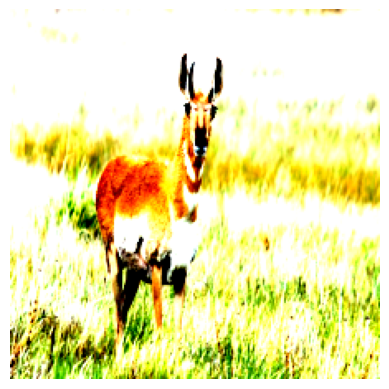

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

i=dataset_for_visualisation[0]                                                  #0th list of the 0th dataset , 0th list contains 0th image and label:+1 for positive sample 0 for negative sample
img=i[0]
label=i[1]
img=np.transpose(img,(1,2,0))
print(label)
plt.imshow(img)
plt.axis('off')                                                                 # Hide axes
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


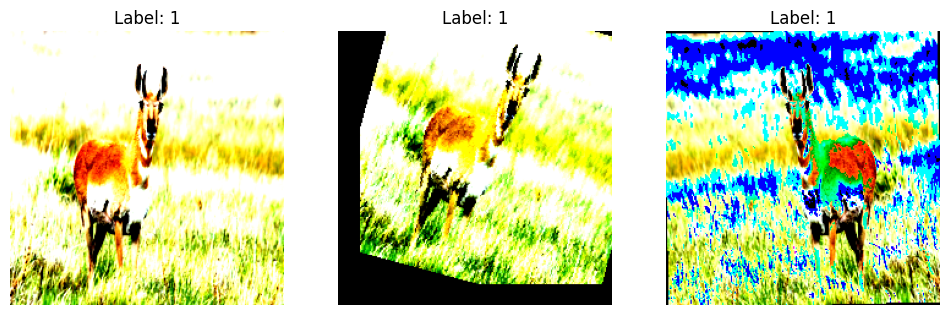

In [ ]:
image_indices=[0,1,2]
index=[0,1,2]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Create subplots with 1 row and 3 columns

for i in index:
    data = dataset_for_visualisation[image_indices[i]]                                             # Get the dataset at the selected index
    img=data[0]
    label=data[1]                                                               # Get the first image and its label
    img = np.transpose(img, (1, 2, 0))                                          #Transpose the image to (height, width, channels) format

    axs[i].imshow(img)
    axs[i].set_title(f'Label: {label}')
    axs[i].axis('off')                                                          # Hide axes

plt.show()

#####Visualisation of -ve example for the dataset created for 'antelope'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


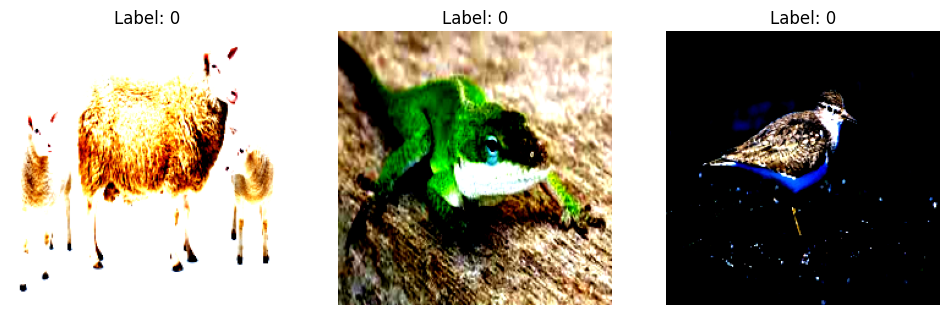

In [ ]:
image_indices=[200,201,202]
index=[0,1,2]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))                                  # Create subplots with 1 row and 3 columns

for i in index:
    data = dataset_for_visualisation[image_indices[i]]                          # Get the dataset at the selected index
    img=data[0]
    label=data[1]                                                               # Get the first image and its label
    img = np.transpose(img, (1, 2, 0))                                          #Transpose the image to (height, width, channels) format

    axs[i].imshow(img)
    axs[i].set_title(f'Label: {label}')
    axs[i].axis('off')                                                          # Hide axes

plt.show()

# RESNET [5 class classification problem]


* I have used kmeans algorithm [k=5] for finding out the 5 clusters.
* VGG 16 is used for representing images and then PCA is used for dimensionality reduction
* k means is then used for clustering
* each animal belonging to same cluster is grouped under same class
* We therefore have 5 classes, and use them for 5 class classification   


### Finding out the 5 classifications

In [ ]:
#For local Runtime

import os
os.chdir('C:/Users/sruma.DESKTOP-LFIURDI/Downloads/animals')    #Folder containing subfolders with animal images.
#Get the current working directory
current_directory = os.getcwd()

#Print the current working directory
print("Current directory:", current_directory)

Current directory: C:\Users\sruma.DESKTOP-LFIURDI\Downloads\animals


In [ ]:
# for loading/processing the images
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [ ]:
os.chdir(current_directory)

In [ ]:
def extract_features(file, model):
    img = load_img(file, target_size=(224,224))                                 # load the image as a 224x224 array
    img = np.array(img)                                                         # convert from 'PIL.Image.Image' to numpy array
    reshaped_img = img.reshape(1,224,224,3)                                     # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    imgx = preprocess_input(reshaped_img)                                       # prepare image for model
    features = model.predict(imgx, use_multiprocessing=True)                    # get the feature vector
    return features


In [ ]:
current_directory

'C:\\Users\\sruma.DESKTOP-LFIURDI\\Downloads\\animals'

In [ ]:
import os


def extract_file_paths(root_folder):
    file_paths = []
    for foldername, _, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.endswith('.jpg'):
              file_paths.append(os.path.join(foldername, filename))

    print("TOTAL ANIMAL IMAGES:",len(file_paths))
    return file_paths

# this list holds all the image filename
animals = extract_file_paths(current_directory)


TOTAL ANIMAL IMAGES: 5400


In [ ]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [ ]:
data = {}
p = r"C:\Users\sruma.DESKTOP-LFIURDI\Downloads\animals\Vectors\animal_features.pkl"

# loop through each image in the dataset
for animal in animals:
    # try to extract the features and update the dictionary
    try:
      feat = extract_features(animal,model)
      data[animal] = feat

    # if something fails, save the extracted features as a pickle file (optional)
    except:
      print("ERROR IN ",animal)
      with open(p,'wb') as file:
        pickle.dump(data,file)



Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 187ms/step


In [ ]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

In [ ]:
feat.shape

(5400, 1, 4096)

In [ ]:
#reshape so that there are 5400 samples of 4096 sized- vectors
feat = feat.reshape(-1,4096)
feat.shape

(5400, 4096)

In [ ]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=50, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [ ]:
# cluster feature vectors
kmeans = KMeans(n_clusters=5,random_state=22)
kmeans.fit(x)

C:\Users\sruma.DESKTOP-LFIURDI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=22)

In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
for i in range(0,100,20):
  print(groups[0][i])

C:\Users\sruma.DESKTOP-LFIURDI\Downloads\animals\antelope\02f4b3be2d.jpg
C:\Users\sruma.DESKTOP-LFIURDI\Downloads\animals\antelope\27a5369441.jpg
C:\Users\sruma.DESKTOP-LFIURDI\Downloads\animals\antelope\72e3e735f7.jpg
C:\Users\sruma.DESKTOP-LFIURDI\Downloads\animals\bat\8ed76190d8.jpg
C:\Users\sruma.DESKTOP-LFIURDI\Downloads\animals\bison\1a993de5a8.jpg


In [ ]:
animal_group_count={}

for k in groups.keys():
  for fp in groups[k]:
    components = fp.split("\\")
    animal_name = components[-2]

    if animal_name not in animal_group_count.keys():
      animal_group_count[animal_name]={}

    if k not in animal_group_count[animal_name].keys():
      animal_group_count[animal_name][k]=1

    else:
      animal_group_count[animal_name][k] += 1


In [ ]:
print(len(animal_group_count))

90


In [ ]:
animal_group_count

{'antelope': {0: 59, 1: 1},
 'badger': {0: 1, 1: 58, 2: 1},
 'bat': {0: 1, 1: 8, 2: 36, 4: 13, 3: 2},
 'bear': {0: 12, 1: 44, 2: 4},
 'bison': {0: 60},
 'boar': {0: 28, 1: 32},
 'cat': {0: 5, 1: 9, 2: 46},
 'caterpillar': {0: 1, 1: 2, 2: 32, 4: 1, 3: 24},
 'cow': {0: 53, 2: 4, 4: 3},
 'coyote': {0: 53, 1: 3, 2: 4},
 'deer': {0: 58, 1: 1, 2: 1},
 'dog': {0: 21, 1: 2, 2: 37},
 'donkey': {0: 60},
 'elephant': {0: 50, 1: 2, 2: 8},
 'flamingo': {0: 4, 2: 40, 4: 16},
 'fox': {0: 47, 1: 10, 2: 3},
 'goat': {0: 56, 1: 1, 2: 3},
 'hare': {0: 37, 1: 19, 2: 1, 4: 3},
 'hippopotamus': {0: 21, 1: 16, 2: 23},
 'horse': {0: 55, 2: 4, 4: 1},
 'hyena': {0: 58, 1: 2},
 'kangaroo': {0: 60},
 'koala': {0: 1, 1: 56, 2: 3},
 'leopard': {0: 16, 2: 44},
 'lion': {0: 56, 1: 1, 2: 3},
 'lizard': {0: 1, 2: 52, 4: 5, 3: 2},
 'okapi': {0: 60},
 'orangutan': {0: 3, 1: 56, 2: 1},
 'otter': {0: 1, 1: 39, 2: 15, 4: 5},
 'ox': {0: 51, 2: 9},
 'panda': {0: 1, 1: 58, 2: 1},
 'penguin': {0: 2, 1: 5, 2: 5, 4: 48},
 'pig': 

In [ ]:
animal_group_mapping={}
group_animal_mapping={}

In [ ]:
for animal in animal_group_count.keys():
  d=animal_group_count[animal]
  if len(d)==1:
    for grp in d.keys():
      animal_group_mapping[animal]=grp
  else:
    max_grp = max(d, key=lambda k: d[k])
    animal_group_mapping[animal]=max_grp



In [ ]:
for animal in animal_group_mapping:
  grp=animal_group_mapping[animal]

  if grp not in group_animal_mapping.keys():
    group_animal_mapping[grp]=[]

  group_animal_mapping[grp].append(animal)

In [ ]:
for grp in group_animal_mapping:
  print(grp,len(group_animal_mapping[grp]),group_animal_mapping[grp])

0 23 ['antelope', 'bison', 'cow', 'coyote', 'deer', 'donkey', 'elephant', 'fox', 'goat', 'hare', 'horse', 'hyena', 'kangaroo', 'lion', 'okapi', 'ox', 'pig', 'reindeer', 'rhinoceros', 'sheep', 'tiger', 'wolf', 'zebra']
1 18 ['badger', 'bear', 'boar', 'koala', 'orangutan', 'otter', 'panda', 'possum', 'raccoon', 'squirrel', 'chimpanzee', 'gorilla', 'hamster', 'hedgehog', 'mouse', 'porcupine', 'rat', 'wombat']
2 24 ['bat', 'cat', 'caterpillar', 'dog', 'flamingo', 'hippopotamus', 'leopard', 'lizard', 'seal', 'crab', 'dolphin', 'goldfish', 'jellyfish', 'lobster', 'moth', 'octopus', 'oyster', 'seahorse', 'shark', 'snake', 'squid', 'starfish', 'turtle', 'whale']
4 16 ['penguin', 'turkey', 'crow', 'duck', 'owl', 'eagle', 'goose', 'hornbill', 'parrot', 'pelecaniformes', 'pigeon', 'sandpiper', 'sparrow', 'swan', 'woodpecker', 'hummingbird']
3 9 ['bee', 'beetle', 'butterfly', 'cockroach', 'dragonfly', 'fly', 'grasshopper', 'ladybugs', 'mosquito']


###Creating dataset for this classificarion problem

In [ ]:
import os

DATASET_DIR = current_directory
#we have animal label mapping in animal_group_mapping
LABELS = [0, 1, 2, 3, 4]

def create_image_path_lists():
    """Creates five lists of image paths for each class label.

    Returns:
        A dictionary of five lists, where each key is a label (0, 1, 2, 3, 4)
        and the corresponding value is a list of image paths belonging to that class.
    """

    image_path_lists = {label: [] for label in range(5)}  # Initialize five empty lists

    for subfolder, label in animal_group_mapping.items():
        # Check if label is valid (within 0-4 range)
        if not (0 <= label <= 4):
            print(f"Warning: Skipping animal '{subfolder}' due to invalid label {label}")
            continue

        for filename in os.listdir(os.path.join(DATASET_DIR, subfolder)):
            image_path = os.path.join(DATASET_DIR, subfolder, filename)
            image_path_lists[label].append(image_path)

    return image_path_lists


In [ ]:
image_path_lists = create_image_path_lists()
print("Image path lists created:")
total_images=0

for label, paths in image_path_lists.items():
  print(f"Label {label}: {len(paths)} images")
  total_images=total_images+len(paths)

print("\nTOTAL IMAGES ",total_images)


Image path lists created:
Label 0: 1380 images
Label 1: 1080 images
Label 2: 1440 images
Label 3: 540 images
Label 4: 960 images

TOTAL IMAGES  5400


###Training RESNET

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, image_path_lists, transform=None):
        self.image_path_lists = image_path_lists
        self.transform = transform

    def __len__(self):
        return sum(len(paths) for paths in self.image_path_lists.values())

    def __getitem__(self, idx):
        # Determine label and actual index within that label's list
        for label, paths in self.image_path_lists.items():
            if idx < len(paths):
                image_path = paths[idx]
                break
            idx -= len(paths)

        # Load image
        image = Image.open(image_path).convert('RGB')

        # Apply transformations if any
        if self.transform:
          image = self.transform(image)

        return image, label

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),                                                # Resize to fit ResNet input size
    transforms.ToTensor(),                                                        # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # Normalize
])

In [ ]:
# Create custom dataset with augmentation
custom_dataset = CustomDataset(image_path_lists, transform=transform)

# Create DataLoader
batch_size = 10
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [ ]:
from sklearn.model_selection import KFold
import torch.nn.functional as F

num_epochs = 15
validation_accuracy=[]

# Define number of folds
num_folds = 3
kf = KFold(n_splits=num_folds)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features

# Define the new fully connected layer
hidden_size = 256
output_size = 5                                                                 # Since it's 5 class classification

# Replace the final fully connected layer with multiple layers
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)
)


# Training loop with 3-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(custom_dataset)):

    print("-------------------"*5)
    print("Fold Number ",fold+1)
    train_dataset = torch.utils.data.Subset(custom_dataset, train_index)
    val_dataset = torch.utils.data.Subset(custom_dataset, val_index)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()

    for epoch in range(num_epochs):
        print(f"In epoch {epoch} for Fold {fold + 1}")
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_dataset)
        #print(f'Training Loss: {epoch_loss:.4f}')

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    print(f'Validation Accuracy for Fold {fold + 1}: {val_acc:.4f}')
    validation_accuracy.append(val_acc)

print('Training finished!')
torch.save(model.state_dict(), 'resnet_model_5_class_classification.pth')

-----------------------------------------------------------------------------------------------
Fold Number  1
In epoch 0 for Fold 1
In epoch 1 for Fold 1
In epoch 2 for Fold 1
In epoch 3 for Fold 1
In epoch 4 for Fold 1
In epoch 5 for Fold 1
In epoch 6 for Fold 1
In epoch 7 for Fold 1
In epoch 8 for Fold 1
In epoch 9 for Fold 1
In epoch 10 for Fold 1
In epoch 11 for Fold 1
In epoch 12 for Fold 1
In epoch 13 for Fold 1
In epoch 14 for Fold 1
Validation Accuracy for Fold 1: 0.1006
-----------------------------------------------------------------------------------------------
Fold Number  2
In epoch 0 for Fold 2
In epoch 1 for Fold 2
In epoch 2 for Fold 2
In epoch 3 for Fold 2
In epoch 4 for Fold 2
In epoch 5 for Fold 2
In epoch 6 for Fold 2
In epoch 7 for Fold 2
In epoch 8 for Fold 2
In epoch 9 for Fold 2
In epoch 10 for Fold 2
In epoch 11 for Fold 2
In epoch 12 for Fold 2
In epoch 13 for Fold 2
In epoch 14 for Fold 2
Validation Accuracy for Fold 2: 0.4617
------------------------------

Validation accuracy turns out to be : 10.06%, 46.17% , 16.39 %

The model trained on such dataset will not solve our purpose.

Why?

* Very different visually looking animals belong to same class
- If you see the grouping of animals,
  - cat and caterpillar both belong in group 2,
  - gorilla and squirrel both belong in group 1
  - hamster and chimpanzee both belong in group 1
  - bat and crab both belong in group 2
  - sheep and lion both belong in group 0

- only animals in group 3 and group 4 look kind of similar.

#Custom CNN [ 1 vs all ]

* In the OvR approach, we train a separate binary classifier for each class in the dataset.
* Each classifier is trained to distinguish instances of its corresponding class from instances of all other classes.
* We have 90 Classes, Therefore I have trained 90 models.

So in order to solve this,

For each model,

* I have Oversampled the + ve examples
> I have used 2 transformations to create new images, in order to compensate for lack of +ve examples. In total, I will now have 180 positive samples [ 120 new , 60 old ]

* I have Undersample the -ve examples
> 90 Images from rest of the classes will be randomly chosen as negative exmaples

So in order to solve this,

For each model,

* I have Oversampled the + ve examples
> I have used 2 transformations to create new images, in order to compensate for lack of +ve examples. In total, I will now have 240 positive samples [ 180 new , 60 old ]

* I have Undersample the -ve examples
> 100 Images from rest of the classes will be randomly chosen as negative exmaples


### Dataset Generation

In [ ]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import random
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [ ]:
!pip install -q tensorflow


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#Define Data Transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                                               # Resize images to 224x224
    transforms.ToTensor(),                                                       # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet mean and standard deviation
])

# Define transformations for data augmentation
augmentation_transforms1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.RandomRotation(degrees=20),  # Randomly rotate the image by up to 20 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformation (translation)
    transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image using ImageNet mean and standard deviation
])

augmentation_transforms2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),   # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=5),  # Randomly rotate the image by up to 20 degrees
    transforms.RandomGrayscale(p=0.2),  # Randomly convert the image to grayscale with probability 0.1
    transforms.RandomSolarize(threshold=200),  # Randomly apply the solarization effect to the image
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image using ImageNet mean and standard deviation
])

augmentation_transforms3 = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to 256x256
    transforms.RandomCrop((224, 224)),  # Randomly crop a region of size 224x224
    transforms.RandomRotation(degrees=30),  # Randomly rotate the image by up to 30 degrees
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # Apply random perspective transformation
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random'),  # Random erasing with probability 0.2
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image using ImageNet mean and standard deviation
])

In [ ]:
#Load Dataset:
dataset = ImageFolder(root=current_directory, transform=data_transforms)

In [ ]:
all_labels=dataset.classes
print(all_labels)

['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


In [ ]:
d_mapping_num_to_label={}

In [ ]:
def get_dataset(target_value):

    d_mapping_num_to_label[target_value] = all_labels[target_value]

    # Separate class images
    class_images = [img_path for img_path, label_image in dataset.imgs if label_image == target_value]  # Images from current class
    rest_images =  [img_path for img_path, label_image in dataset.imgs if label_image != target_value]  # Images from other classes

    augmented_class_images = []
    for img_path in class_images:
        img = Image.open(img_path)

        original_img = data_transforms(img)
        augmented_img1 = augmentation_transforms1(img)
        augmented_img2 = augmentation_transforms2(img)
        augmented_img3 = augmentation_transforms3(img)

        augmented_class_images.append([original_img, 1])                        # 1 for positive sample
        augmented_class_images.append([augmented_img1, 1])
        augmented_class_images.append([augmented_img2, 1])
        augmented_class_images.append([augmented_img3, 1])

    rest_class_images = []

    # Select random images from the rest of the folders
    number_of_random_images = 100
    seed = 54
    random.seed(seed)
    random_rest_images = random.sample(rest_images, number_of_random_images)

    for img_path in random_rest_images:
        img = Image.open(img_path)
        original_img = data_transforms(img)
        rest_class_images.append([original_img, 0])  # 0 for negative sample

    # Create a new dataset by combining augmented class images and random rest images
    new_dataset = augmented_class_images + rest_class_images

    return new_dataset

### Showing 1 image from dataset from veification purpose

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


340


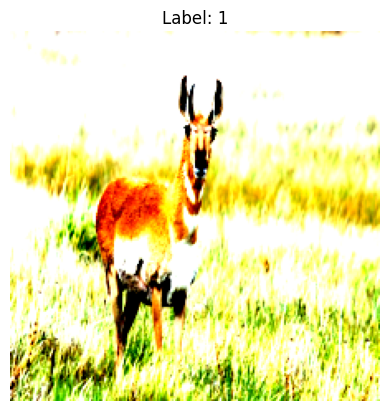

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

nd=get_dataset(0)
print(len(nd))

#print(nd[0][0].shape) : torch.Size([3, 224, 224])

#nd[0][0] contains the image data and nd[0][1] contains the label
image = nd[0][0]  # Extract image data
label = nd[0][1]  # Extract label

# Transpose the image data to the correct shape (assuming channels are the first dimension)
image = np.transpose(image, (1, 2, 0))

# Display the image
plt.imshow(image)
plt.title(f"Label: {label}")  # Add title with the label
plt.axis('off')  # Turn off axis
plt.show()


### Training CNN model

In [ ]:
import numpy as np
from keras import models, layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
conf_matrices=[]
test_accuracy=[]

In [ ]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

for i in range(len(all_labels)):
  print("Training MODEL for ",all_labels[i])
  nd=get_dataset(0)
  # Split the dataset into train and test sets
  inputs, labels = zip(*nd)
  inputs_np = np.array([input_tensor.permute(1, 2, 0).numpy() for input_tensor in inputs])  # Convert PyTorch tensors to NumPy arrays
  labels_np = np.array(labels)
  train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs_np, labels_np, test_size=0.2, random_state=42)

  # Define input shape
  input_shape = (224, 224, 3)  # Height, Width, Channels

  # Create the model
  model = models.Sequential()

  # Convolutional layers
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())

  # Dense layers
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))

  # Output layer
  model.add(layers.Dense(2, activation='softmax'))  # Softmax activation for binary classification

  # Compile the model
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Since we're using integers as labels
              metrics=['accuracy'])

  # Train the model
  batch_size = 20
  num_epochs = 15
  model.fit(train_inputs, train_labels, epochs=num_epochs, batch_size=batch_size, validation_data=(test_inputs, test_labels))

  # Evaluate the model
  loss, accuracy = model.evaluate(test_inputs, test_labels)
  test_accuracy.append(accuracy)
  #print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

  # Get predictions for the test set
  predictions = model.predict(test_inputs)
  predicted_labels = np.argmax(predictions, axis=1)

  # Generate confusion matrix
  cm = confusion_matrix(test_labels, predicted_labels)

  conf_matrices.append(cm)
  print("----------------------------------------------------------------------"*2)
  print("\n")


Training MODEL for  antelope
Epoch 1/15
14/14 [==============================] - 7s 403ms/step - loss: 0.7126 - accuracy: 0.6581 - val_loss: 0.6034 - val_accuracy: 0.7059
Epoch 2/15
14/14 [==============================] - 5s 354ms/step - loss: 0.5941 - accuracy: 0.7059 - val_loss: 0.5343 - val_accuracy: 0.7059
Epoch 3/15
14/14 [==============================] - 5s 356ms/step - loss: 0.5390 - accuracy: 0.7096 - val_loss: 0.5062 - val_accuracy: 0.7500
Epoch 4/15
14/14 [==============================] - 5s 350ms/step - loss: 0.4812 - accuracy: 0.7757 - val_loss: 0.4067 - val_accuracy: 0.7647
Epoch 5/15
14/14 [==============================] - 5s 355ms/step - loss: 0.4030 - accuracy: 0.7941 - val_loss: 0.3905 - val_accuracy: 0.8676
Epoch 6/15
14/14 [==============================] - 5s 338ms/step - loss: 0.3643 - accuracy: 0.8382 - val_loss: 0.3284 - val_accuracy: 0.8088
Epoch 7/15
14/14 [==============================] - 5s 343ms/step - loss: 0.3016 - accuracy: 0.8529 - val_loss: 0.2835 

### Confusion matrices and Test Accuracy

In [ ]:
import json

#Storing Confusion matrices for processing in further sessions

#Convert NumPy arrays to lists
converted_list = [arr.tolist() for arr in conf_matrices]

# Save list to a JSON file
with open('conf_matrices.json', 'w') as f:
    json.dump(converted_list, f)


In [ ]:
# Load list from a JSON file
with open('conf_matrices.json', 'r') as f:
    conf_matrices = json.load(f)

print(conf_matrices)

[[[13, 7], [6, 42]], [[17, 3], [3, 45]], [[16, 4], [0, 48]], [[13, 7], [6, 42]], [[13, 7], [1, 47]], [[20, 0], [3, 45]], [[8, 12], [4, 44]], [[14, 6], [1, 47]], [[13, 7], [3, 45]], [[16, 4], [4, 44]], [[13, 7], [2, 46]], [[10, 10], [1, 47]], [[12, 8], [0, 48]], [[19, 1], [4, 44]], [[13, 7], [2, 46]], [[16, 4], [7, 41]], [[15, 5], [7, 41]], [[19, 1], [13, 35]], [[14, 6], [8, 40]], [[14, 6], [3, 45]], [[15, 5], [6, 42]], [[11, 9], [2, 46]], [[16, 4], [2, 46]], [[17, 3], [4, 44]], [[18, 2], [7, 41]], [[18, 2], [6, 42]], [[13, 7], [4, 44]], [[18, 2], [7, 41]], [[13, 7], [3, 45]], [[14, 6], [4, 44]], [[16, 4], [2, 46]], [[11, 9], [2, 46]], [[13, 7], [0, 48]], [[18, 2], [4, 44]], [[14, 6], [4, 44]], [[14, 6], [5, 43]], [[17, 3], [6, 42]], [[12, 8], [5, 43]], [[11, 9], [0, 48]], [[15, 5], [7, 41]], [[18, 2], [7, 41]], [[15, 5], [4, 44]], [[14, 6], [9, 39]], [[13, 7], [1, 47]], [[11, 9], [3, 45]], [[15, 5], [3, 45]], [[13, 7], [4, 44]], [[18, 2], [5, 43]], [[12, 8], [4, 44]], [[15, 5], [4, 44]

Due to a bug in seaborn/matplotlib, not able to visualize Confusion matrices in heatmap

https://stackoverflow.com/questions/77165100/only-the-first-row-of-annotations-displayed-on-seaborn-heatmap

In [ ]:
conf_matrices[0]

[[13, 7], [6, 42]]

In [ ]:
#Storing test accuracy for processing in further sessions
import json

# Save list to a JSON file
with open('test_accuracy.json', 'w') as f:
    json.dump(test_accuracy, f)


In [ ]:
# Load list from a JSON file
with open('test_accuracy.json', 'r') as f:
    test_accuracy= json.load(f)


In [ ]:
test_accuracy[0],test_accuracy[1]

(0.8088235259056091, 0.9117646813392639)

#Custom CNN [5 class classification]